# Meet the meat - Data Analysis

## Abstract

With increasingly dire climate change forecasts, concerned individuals are asking how they can minimize their carbon footprint. Recent research suggests that reducing one's consumption of meat, in particular beef, is one of the highest impact actions an individual can take. To examine this topic, we will explore the popularity and prevalence of meat in recipes. Specifically, we plan to extract the ingredients from a recipe database and calculate the carbon footprint of recipes

Finally, we hope to directly relate this data to the issue of climate change by estimating a rating reflecting the carbon footprint of meat in recipes and the environmental impact of consumers' diets.

### Imports and libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Import libraries
import re
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline   


import nltk  #to install: activate ada,   conda install -c anaconda nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
#nltk.download('stopwords')

from ast import literal_eval
import string

import seaborn as sns
sns.set(style="whitegrid")

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

#to install: conda install -c conda-forge wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string
import spacy, nltk, gensim, sklearn
from sklearn.decomposition import PCA

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from ast import literal_eval
import string

import seaborn as sns
sns.set(style="whitegrid")

#create a constant seed so the random number sequence will always be the same
seed = 42
random.seed(seed)
np.random.seed(seed)

nlp = spacy.load('en')

In [2]:
# Define the Fontsize parameters for the plots:
FontSize=14
plt.rcParams['axes.labelsize']=FontSize
plt.rcParams['xtick.labelsize']=FontSize
plt.rcParams['ytick.labelsize']=FontSize
plt.rcParams['legend.fontsize']=FontSize

## Data loading and cleaning
In the Data Extraction part (notebook for MS2), we extract all the information we need from the HTML files dataset, and save it as a CSV file for further analysis. In this second part, we load the data from the CSV file, do some extra cleaning and processing before drawing conclusions from our research.

For the statistical analysis of the data we drop all recipes for which we were not able to properly retrieve the amount of meat ingredients in order to not create artificial spikes in the distributions. In a later time however we assign the median amount to every type of meat. Although we did most of the data cleaning in the previous notebook, we still need to clean out titles from the CSV file, annd remove outliers or other discrepancies that arose when analysing the data from our csv file.

In [3]:
#Import CSV
DATA_FOLDER='data'#/data_full'
df=pd.read_csv(DATA_FOLDER+'/recipes_data_full.csv')#.csv')

In order to compare carbon footprints of recipes, we normalise the recipes per serving.

In [4]:
def normalize_servings(c_f, servs):
    #input is ingredient quantity in kg
    #interpret servings as a total quantity using the check_quantity function
    tot_servs = servs.str.extract(r'(\d+)')#find value
    tot_servs=tot_servs.fillna(value='2') #replace missing values with 2
    tot_servs=tot_servs.astype(int) #convert to int
    c_f_norm=c_f/tot_servs[0]
    return c_f_norm

In [5]:
#Remove the '\n', '\r' and '\t' produced by the CSV/dataframe conversion
df_clean = df.copy()
df_clean['Recipe Title'] = df_clean['Recipe Title'].str.replace('\n', '').str.replace('\t', '').str.replace('\r', '')
df_clean['Servings'] = df_clean['Servings'].str.replace('\n', '').str.replace('\t', '').str.replace('\r', '')

#normalise carbon footprint per servings
df_clean['Carbon footprint'] = normalize_servings(df_clean['Carbon footprint'],df_clean['Servings'])
df_clean = df_clean.rename(columns = {'Carbon footprint':'Carbon footprint- Normalised'}, inplace = False)

# drop all recipes for which we have NaN or inf values in Carbon footprint or Rating
df_clean=df_clean.replace([np.inf,-np.inf], np.nan).dropna(subset=["Carbon footprint- Normalised", "Rating"], how="any")

# drop all recipes with an extravagant carbon footprint
#df_clean = df_clean[df_clean['Carbon footprint- Normalised'] < 70]

#Create seperate dataframes for recipes with and without ingredient in the high carbon footprint list:
df_meat = df_clean[df_clean['Has meat']]
df_meat = df_meat[df_meat['Carbon footprint- Normalised'] > 0.001]
df_no_meat = df_clean[df_clean['Has meat']==False]

df_clean.head()

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint- Normalised,Rating,Website,Servings
0,French Dip Sandwiches Recipe : Rachael Ray : R...,True,"['beef', 'beef', 'beef']","[0, 0.6802721088435374, 0]",4.591837,5.0,food network,4 servings
3,Baked Buffalo Wings Recipe - Allrecipes.com,True,['chicken'],[0],0.000000,4.4,allrecipes,20 chicken wings
5,Fast Rice Pudding Recipe - Allrecipes.com,False,[],0,0.000000,4.1,allrecipes,3 servings
7,Chicken Breast Cutlets with Artichokes and Cap...,True,"['chicken', 'chicken']","[0.9070294784580498, 0]",1.043084,4.4,allrecipes,6 servings
8,Best Ever Popcorn Balls Recipe - Allrecipes.com,False,[],0,0.000000,4.4,allrecipes,20 popcorn balls


## First statistical Exploration of the Data

### Descriptive Statistics
We have collected the information of near 30'000 recipes. 10785 do not contain any ingredient figuring in the list of high carbon footprint ingredients whereas 14898 do have high carbon-impact ingredients. The mean rating of 4.40/5 is slightly lower in recipes containing meat than in recipes without with a mean of 4.42.

In [6]:
print('All Recipes:')
print(df_clean.describe())
print('Recipes containing high carbon footprint ingredients:')
print(df_meat.describe())
print('Recipes without high carbon footprint ingredients:')
print(df_no_meat.describe())

All Recipes:
       Carbon footprint- Normalised        Rating
count                  29357.000000  29357.000000
mean                       1.159385      4.412515
std                        7.629383      0.539985
min                        0.000000      0.000000
25%                        0.000000      4.200000
50%                        0.002057      4.500000
75%                        0.239199      4.700000
max                      329.725000      5.000000
Recipes containing high carbon footprint ingredients:
       Carbon footprint- Normalised        Rating
count                  14898.000000  14898.000000
mean                       2.284603      4.401671
std                       10.589273      0.530627
min                        0.001029      0.000000
25%                        0.019200      4.200000
50%                        0.201600      4.500000
75%                        1.768781      4.700000
max                      329.725000      5.000000
Recipes without high carbon footp

Text(0.5,1,'Ratings: no meat')

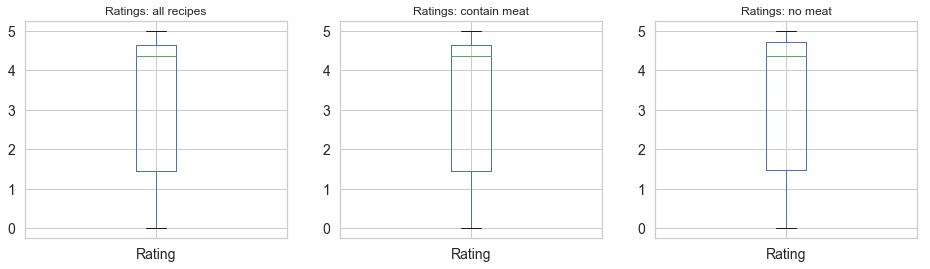

In [9]:
plt.figure(figsize=(16,4))

plt.subplot(131)
df_clean.describe().iloc[2:].boxplot(column='Rating')
plt.title('Ratings: all recipes')

plt.subplot(132)
df_meat.describe().iloc[2:].boxplot(column='Rating')
plt.title('Ratings: contain meat')

plt.subplot(133)
df_no_meat.describe().iloc[2:].boxplot(column='Rating')
plt.title('Ratings: no meat')

We can observe that whatever the recipe composition (meat ingrdients or not) the ratings have a similar distribution.

Text(0.5,1,'Carbon footprint: contain meat, CO2eq < 5kg')

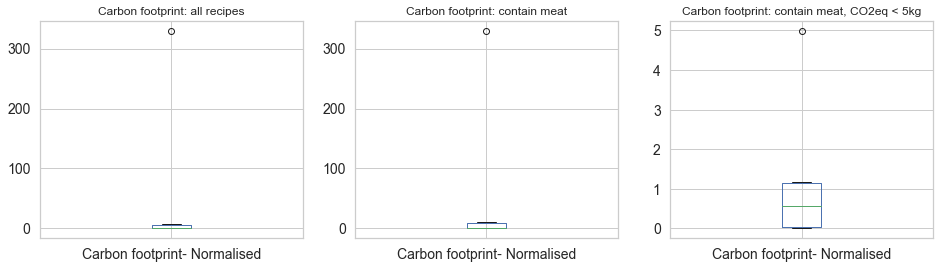

In [8]:
plt.figure(figsize=(16,4))
plt.title('Carbon footprint of recipes')

plt.subplot(131)
df_clean.describe().iloc[2:].boxplot(column='Carbon footprint- Normalised')
plt.title('Carbon footprint: all recipes')

plt.subplot(132)
df_meat.describe().iloc[2:].boxplot(column='Carbon footprint- Normalised')
plt.title('Carbon footprint: contain meat')

plt.subplot(133)
df_meat[df_meat['Carbon footprint- Normalised'] < 5].describe().iloc[2:].boxplot(column='Carbon footprint- Normalised')
plt.title('Carbon footprint: contain meat, CO2eq < 5kg')

We can clearly see in the boxplots above that there are some outliers with carbon footprints orders of magnitude above other values, which might result from data extraction errors such as a meat recipe for a crowd labelled as one serving.

### Correlations

In [7]:
print('Spearman Correlation for all recipes:')
print(df_clean.corr(method='spearman'))
print('Spearman Correlation for meat recipes:')
print(df_meat.corr(method='spearman'))

Spearman Correlation for all recipes:
                              Has meat  Carbon footprint- Normalised    Rating
Has meat                      1.000000                      0.716639 -0.040719
Carbon footprint- Normalised  0.716639                      1.000000 -0.007793
Rating                       -0.040719                     -0.007793  1.000000
Spearman Correlation for meat recipes:
                              Has meat  Carbon footprint- Normalised    Rating
Has meat                           NaN                           NaN       NaN
Carbon footprint- Normalised       NaN                      1.000000  0.075395
Rating                             NaN                      0.075395  1.000000


The figures above show that there is no appearent correlation between carbon footpring and ratings. 

###  First Visual Exploration

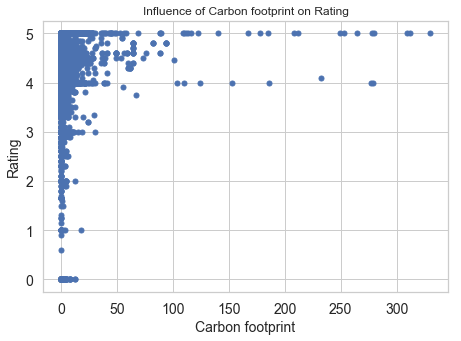

In [10]:
# Scatterplot:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.scatter(df_clean['Carbon footprint- Normalised'], df_clean['Rating'], s=25) 
plt.title('Influence of Carbon footprint on Rating')
plt.xlabel('Carbon footprint')
plt.ylabel('Rating')
plt.show()

We can see that many of the high-impact recipes have a high rating. While the low-impact recipes span all ratings, they are more concentrated in the upper numbers.

## Designing a Green Tag for each recipe based on its carbon footprint

Inspired by the tags we find on electronic devices. The recipes without any ingredient figuring in the list of meat types gets tag AA. The rest of the cathegories are established by grouping the recipes into 5 quantiles based on their carbon footprint. With the tag one has access to the information on how bad or how good one is doing compared to the rest of the recipes. We think that this gives a more intuitive estimate for the cook than some number. However, we would like to strike, that between two subsequent labels we observe a difference or around one order of magnitude. This means that for the same carbon footprint of a meal from category E you can cook 100 meals from category C.

In [11]:
# Define colors for each Tag:
color_AA = 'green'
color_A = 'limegreen'
color_B = 'gold'
color_C = 'orange'
color_D = 'red'
color_E = 'darkred'
color_list = [color_AA, color_A, color_B, color_C, color_D, color_E]
tig_list = ['AA', 'A', 'B', 'C', 'D', 'E']

In [12]:
# All Recipes without meat or cheese or eggs receive a rating AA
#df_no_meat['Label']='AA'
A = df_meat['Carbon footprint- Normalised'].quantile(q=0.2)
B = df_meat['Carbon footprint- Normalised'].quantile(q=0.4)
C = df_meat['Carbon footprint- Normalised'].quantile(q=0.6)
D = df_meat['Carbon footprint- Normalised'].quantile(q=0.8)
E = df_meat['Carbon footprint- Normalised'].max()

print("The Carbon footprint is labelled as follows:")
print("A = 0 - ",A)
print("B = ", A, " - ",B)
print("C = ", B, " - ",C)
print("D = ", C, " - ",D)
print("E = ", D, " - ",E)

The Carbon footprint is labelled as follows:
A = 0 -  0.0144
B =  0.0144  -  0.0576
C =  0.0576  -  0.57407722401769
D =  0.57407722401769  -  2.6077097505668934
E =  2.6077097505668934  -  329.725


In [13]:
df_no_meat = df_no_meat.assign(Label = 'AA')
df_no_meat = df_no_meat.sort_values(by=['Rating'],ascending=False)
df_meat['Label'] = pd.qcut(df_meat['Carbon footprint- Normalised'], 5, labels=['A','B','C','D','E'],precision=1000)
df_meat = df_meat.sort_values(by=['Label','Rating'],ascending=[True,False])
df_clean = pd.concat([df_no_meat,df_meat])

## Correlations between appreciation and Environmental Impact of a Recipe
As we did not observe a clear correlation the first analysis we explore other means of retrieving information from our dataset.

### Visual Exploration
First we make a hexabin plot for the number of recipes as a function of rating and carbon footprint. We use only recipes with carbon footprint not equal to zero. This gives us the possibility of a log plot, which corresponds also to the logarithmic behaviour of the Green Labels. We observe that there is some pattern in which the recipes are grouped. For our work this plot is very promising, as it shows, that there are many alternative recipes with the same rating or higher for recipes with a high carbon footprint.

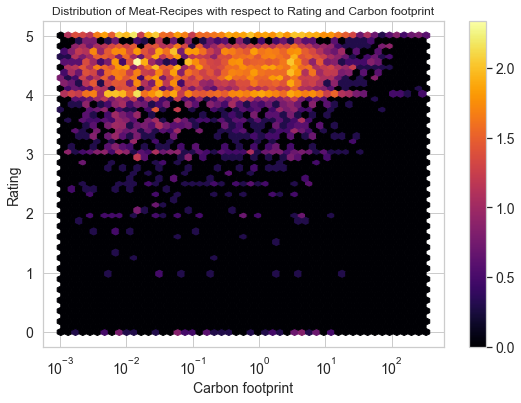

In [14]:
## Hexabinplot of data containing meat, need log plot for x-axis->no zero values
plt.figure(figsize=(9,6))
plt.set_cmap('inferno')
plt.hexbin(df_meat['Carbon footprint- Normalised'], df_meat['Rating'], gridsize=50, bins='log', xscale='log') 
plt.title('Distribution of Meat-Recipes with respect to Rating and Carbon footprint')
plt.xlabel('Carbon footprint')
plt.ylabel('Rating')
plt.colorbar()
#plt.savefig('hexabin.eps')
plt.show()

Now we look at this histogram of recipes without any ingredient in the high carbon footprint list and the recipes in category A - E. We can see that a higher percentage of recipes with no meat receive an excellent rating. Good News for the planet!!

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df_no_meat['Rating'], bins=np.linspace(0,5,10), histtype='step', density=True,\
         color='limegreen', linewidth=1.8, label='Recipes in category AA') 
plt.hist(df_meat['Rating'], bins=np.linspace(0,5,10), histtype='step', density=True, \
         color='red',linewidth=1.8, label='Recipes in category A - E')
plt.xlabel('Rating')
plt.ylabel('Normalized distribution of Recipes')
plt.title('The Distributions of recipes ')
plt.legend(loc=2)
#plt.savefig('DistRec.eps')
plt.show()

### Study of Excellent Recipes

The goal is to cook meals that have only little environmental impact, however the meals should be tasty! This is why we seperately analyse the properties of excellent recipes that we identify with a rating between 4.8 - 5.0. We observe, that both groups AA and E show the highest percentage of excellent recipes.

In [ ]:
#Show only excellent recipes 4.8-5
df_excellent = df_clean[df_clean['Rating']>4.8]
plt.figure(figsize=(8,6))
plt.hist(df_excellent['Carbon footprint- Normalised'], bins=50, log=True, density=True)
plt.xlabel('Carbon footprint- Normalised')
plt.ylabel('# of excellent Recipes')
#plt.title('Distribution of excellent recipes with respect to their Carbon Footprint')
plt.savefig('hist_excellent.eps')
plt.show()

In [16]:
# Group by label and normalize with respect to number of recipes in each group.
h = df_excellent[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='# excellent recipes') \
                         .reindex([1,0,2,3,4,5])
h1 = df_clean[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='#recipes') \
                         .reindex([1,0,2,3,4,5])
df_ex = h.merge(h1)
df_ex['% of excellent recipes'] = df_ex['# excellent recipes']/df_ex['#recipes']

# plot
plt.figure(figsize=(9,6))
plt.bar(df_ex['Label'], df_ex['% of excellent recipes'], \
        color=[color_AA,color_A,color_B,color_C,color_D,color_E], \
        tick_label=tig_list)
plt.xlabel('Green Label')
plt.ylabel('% of excellent Recipes')
plt.title('Which Label has the highest percentage of excellent Recipes with Rating 4.8 - 5.0 ?')
#plt.savefig('excellent.eps')
plt.show()

NameError: name 'df_excellent' is not defined

### Study of Terrible Recipes
For completeness and our curiosity we do the same thing for bad recipes, with rating lower than 2.9. There are some differences between the different categories, but they are too low to be significant.

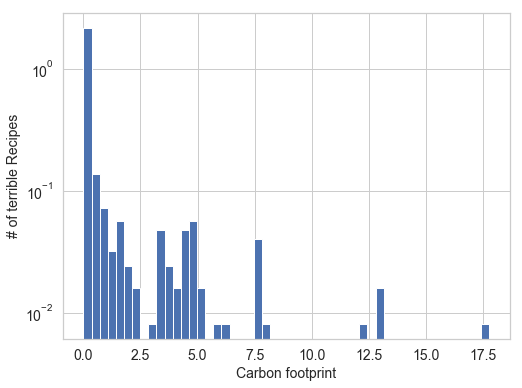

In [15]:
#Show only terrible recipes < 3.0
df_terrible = df_clean[df_clean['Rating']<3.0]
plt.figure(figsize=(8,6))
plt.hist(df_terrible['Carbon footprint- Normalised'], bins=50, log=True, density=True)
plt.xlabel('Carbon footprint')
plt.ylabel('# of terrible Recipes')
#plt.title('Distribution of excellent recipes with respect to their Carbon Footprint')
#plt.savefig('hist_excellent.eps')
plt.show()

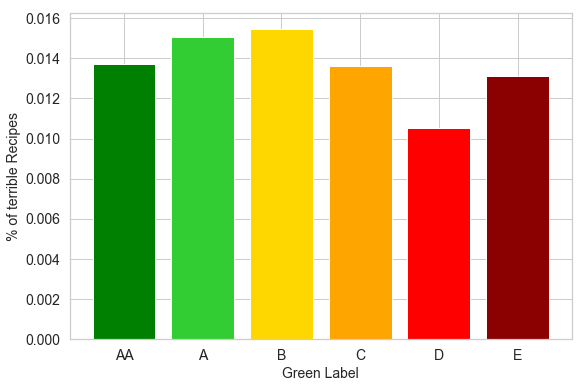

In [17]:
t = df_terrible[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='# excellent recipes') \
                         .reindex([1,0,2,3,4,5])
t1 = df_clean[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='#recipes') \
                         .reindex([1,0,2,3,4,5])
df_ter = t.merge(t1)
df_ter['% of excellent recipes'] = df_ter['# excellent recipes']/df_ter['#recipes']

#plot:

plt.figure(figsize=(9,6))
plt.bar(df_ter['Label'], df_ter['% of excellent recipes'], \
        color=[color_AA,color_A,color_B,color_C,color_D,color_E], \
        tick_label=tig_list)
plt.xlabel('Green Label')
plt.ylabel('% of terrible Recipes')
#plt.title('Which Label has the highest percentage of excellent Recipes with Rating 4.8 - 5.0 ?')
plt.savefig('terrible.eps')
plt.show()

In the graphs above, we can see that the "terrible" recipes also have a worse labels than the excellent recipes. We can only recommend our readers to cook tasty recipes that are also good for the environment! 

### Brief look on the different recipe pages

If we want people to change habits and look into recipes with a lower carbon footprint, we need recipes that are readily available on their favourite websites to support their cooking. 
We observe, that all of the recipe pages feature a high amount of low carbon footprint recipes, and offer therefore alternatives.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214B3AF4588>,
      dtype=object)

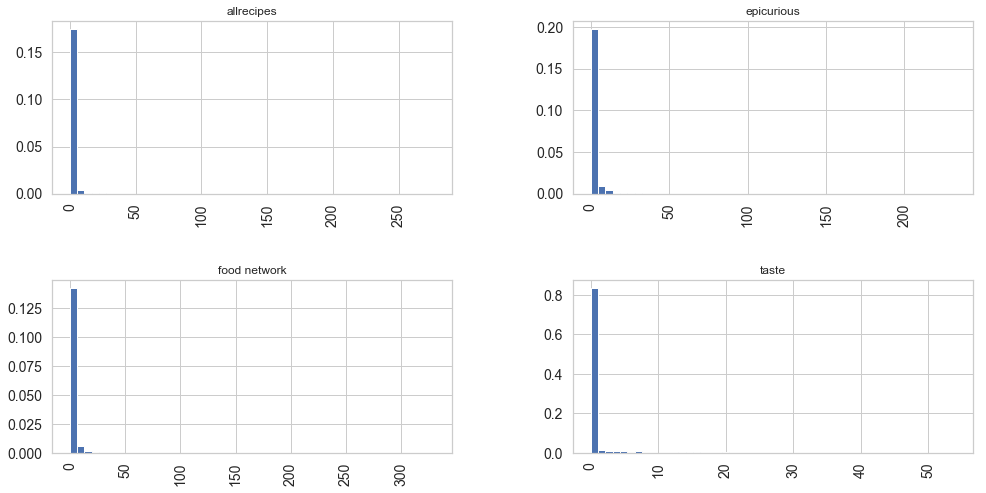

In [18]:
df_clean['Carbon footprint- Normalised'].hist(by=df_clean['Website'],bins=50,figsize=(16,8),\
                                 xlabelsize=FontSize,ylabelsize=FontSize, density=True)

### Data exploration and basic analysis


We now want to explore in more detail the composition of the meat recipes and how they might relate to ratings. 

In [19]:
#sort dataframe
df_sorted_meat = df_meat.sort_values(['Carbon footprint- Normalised'], ascending=False).reset_index(drop=True)

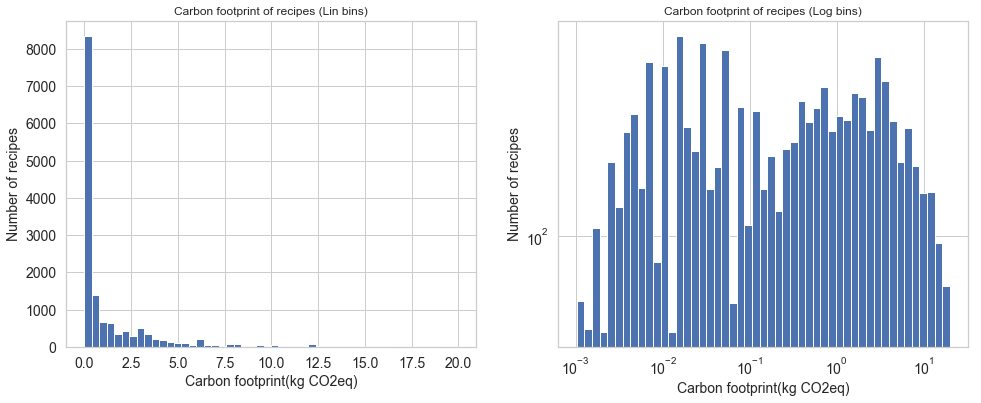

<Figure size 432x288 with 0 Axes>

In [20]:
# We plot the carbon footprints to see how they compare
plt.figure(figsize=(25,6))

data = df_sorted_meat[df_sorted_meat['Carbon footprint- Normalised']<20]['Carbon footprint- Normalised']
logbins=np.logspace(np.log10(np.min(data)),np.log10(np.max(data)),50)
bin_width=logbins[1::]-logbins[:-1]
log_width=(np.log10(logbins[1::])-np.log10(logbins[:-1]))[0]

plt.subplot(131)
plt.hist(data,bins=50) 
plt.title('Carbon footprint of recipes (Lin bins)')
plt.xlabel('Carbon footprint(kg CO2eq)')
plt.ylabel('Number of recipes')

plt.subplot(132)
plt.hist(data,bins=logbins) #bar plot on log-log scale with constant log bins
plt.xscale('log')
plt.yscale('log')
plt.title('Carbon footprint of recipes (Log bins)')
plt.xlabel('Carbon footprint(kg CO2eq)')
plt.ylabel('Number of recipes')

plt.show()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)

We can see the biggest impact recipes have a carbon footprint orders of magnitude above the other recipes' footprint; the tail of the distribution flattens out in the end. As we are aware of some quantity extraction errors in our methodology, it makes sense to get rid of there datapoints. We will only keep recipes with a carbon footprint lower than 10kg CO2 equivalent in further analysis.

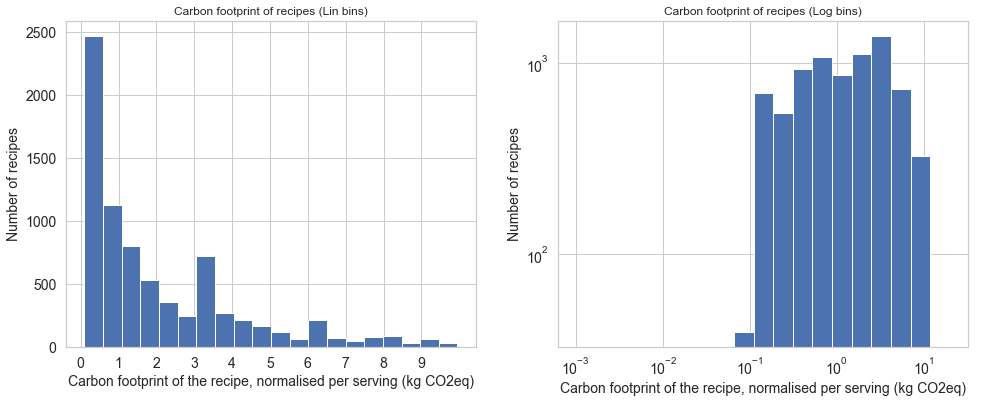

<Figure size 432x288 with 0 Axes>

In [21]:
#remove recipes with a zero score and those with an anormally high footprint
df_sorted_meat_cropped = df_sorted_meat[(df_sorted_meat['Carbon footprint- Normalised'] >= 0.1) &\
                                        (df_sorted_meat['Carbon footprint- Normalised'] <= 10)]

# We plot the carbon footprints to see how they compare
plt.figure(figsize=(25,6))
dmin = np.min(data)
dmax = np.max(data)
ticks = np.arange(0,10,1)

data = df_sorted_meat_cropped['Carbon footprint- Normalised']
logbins=np.logspace(np.log10(dmin),np.log10(dmax),20)

plt.subplot(131)
plt.hist(data,bins=20) 
plt.title('Carbon footprint of recipes (Lin bins)')
plt.xlabel('Carbon footprint of the recipe, normalised per serving (kg CO2eq)')
plt.ylabel('Number of recipes')
plt.xticks(ticks)

plt.subplot(132)
plt.hist(data,bins=logbins) #bar plot on log-log scale with constant log bins
plt.xscale('log')
plt.yscale('log')
plt.title('Carbon footprint of recipes (Log bins)')
plt.xlabel('Carbon footprint of the recipe, normalised per serving (kg CO2eq)')
plt.ylabel('Number of recipes')

plt.show()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)

### Assumptions
We assume we can assign a "median" carbon footprint value to all recipes in which we detected meat ingredients but couldn't extract a meat quantity. 

In [22]:
meat_products = ['lamb', 'beef', 'cheese', 'pork', 'turkey', 'chicken', 'tuna', 'egg']

def normalize_servings(amount, servs):
    #input is ingredient quantity in kg
    #interpret servings as a total quantity using the check_quantity function
    tot_servs = servs.str.extract(r'(\d+)')#find value
    tot_servs=tot_servs.fillna(value='4') #replace missing values with 4
    tot_servs=tot_servs.astype(int) #convert to int
    tot_servs=tot_servs.replace(0, 4) #replace missing values with 4
    amount_norm=amount/tot_servs[0]
    return amount_norm

def meat_quantities(recipe_data):
    '''
    Input: recipe dataframe row. Output: meat quantity dataframe.
    Reads and converts the list of meat ingredients and quantities from string to values then creates
    and returns a DataFrame with all meat quantitities per meat type.
    '''
    columns = literal_eval(recipe_data['Meat types'])
    rows = literal_eval(recipe_data['Meat quantity (kg)'])    
    df = pd.DataFrame(np.array(rows).reshape(1,len(rows)), columns=columns)
    
    
    for meat in meat_products:
        if meat in columns:
            df[meat] = pd.DataFrame(df[meat]).sum(axis=1)
            
    df = df.T.drop_duplicates().T.reindex(labels=meat_products, axis='columns')
    df['Servings'] = recipe_data['Servings']
    df['Rating'] = recipe_data['Rating']
    return df

def meat_quantities_df(dataframe, assign_median=False, normalise=True):
    
    meat_qty_df = pd.DataFrame(columns=meat_products)
    c=0
        
    for i in np.arange(len(dataframe)):
        try:
            new_row = meat_quantities(dataframe.iloc[i])

            for meat in meat_products:
                if ((assign_median == True) & (new_row[meat].iloc[0] != np.nan) & (new_row[meat].iloc[0] <= 0.01)):
                    new_row[meat] = meat_medians[meat]
                    
            meat_qty_df = pd.concat([meat_qty_df,new_row], sort=True)
            
        except:
            c = c+1
            pass
    
    if normalise==True:
        for meat in meat_products:
            meat_qty_df[meat] = normalize_servings(meat_qty_df[meat], meat_qty_df['Servings'])

    #print('exception count: '+str(c))
    
    #if (assign_median == True):
     #   meat_qty_df = meat_qty_df.replace(np.nan, 0)
    
    return meat_qty_df

In [23]:
#We extract the meat quantities for all recipes having quantities extracted, removing very low values
meat_qty_df = meat_quantities_df(df_sorted_meat[df_sorted_meat['Carbon footprint- Normalised'] >= 0.01])

#Now we can extract the median and mean amounts of meat ingredients in recipes
meat_medians = meat_qty_df.median(axis='rows', skipna=True)
meat_means = meat_qty_df.mean(axis='rows', skipna=True)

#Assign this median value to all zeroes in meat quantities
meat_qty_all = meat_quantities_df(df_sorted_meat, assign_median=True)

print(meat_medians)
print(meat_means)

Rating     4.500000
beef       0.113379
cheese     0.025515
chicken    0.083277
egg        0.006000
lamb       0.198413
pork       0.144570
tuna       0.056699
turkey     0.113379
dtype: float64
Rating     4.412845
beef       0.259093
cheese     0.068573
chicken    0.219421
egg        0.010165
lamb       0.361099
pork       0.254973
tuna       0.098474
turkey     0.917154
dtype: float64


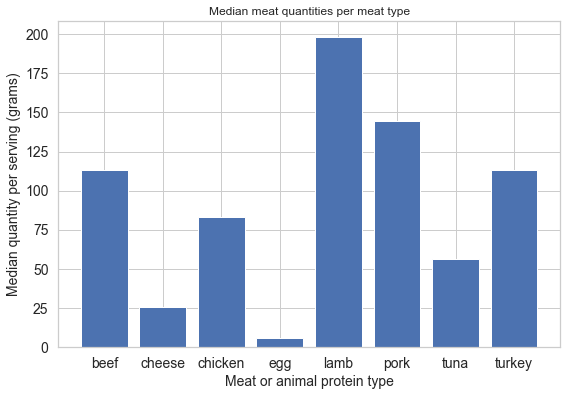

In [24]:
plt.figure(figsize=(9,6))
plt.bar(meat_medians.index[1:], meat_medians[1:]*1000)
plt.xlabel('Meat or animal protein type')
plt.ylabel('Median quantity per serving (grams)')
plt.title('Median meat quantities per meat type')
plt.show()

We can see that median quantities per serving depend strongly on the type of meat. We can note that red meats (beef, lamb) are often served in large quantities which worsens their carbon footprint.

### Clustering

In this section we will attempt to cluster the recipe titles. But first we need to perform some additional cleaning of the data. For instance, there were some recipes that we could not extract the ingredient quantity for. If the recipes contained any of our high impact ingredients, we will use the median carbon footprints calculated above to estimate the carbon footprint of these incomplete recipes.

In [25]:
#Remove the '\n', '\r' and '\t' produced by the CSV/dataframe conversion
df_clean = df.copy()
df_clean['Recipe Title'] = df_clean['Recipe Title'].str.replace('\n', '').str.replace('\t', '').str.replace('\r', '')
df_clean['Servings'] = df_clean['Servings'].str.replace('\n', '').str.replace('\t', '').str.replace('\r', '')

#normalise carbon footprint per servings
df_clean['Carbon footprint'] = normalize_servings(df_clean['Carbon footprint'],df_clean['Servings'])
df_clean = df_clean.rename(columns = {'Carbon footprint':'Carbon footprint- Normalised'}, inplace = False)

# drop all recipes for which we have NaN or inf values in Carbon footprint or Rating
df_clean=df_clean.replace([np.inf,-np.inf], np.nan).dropna(subset=["Carbon footprint- Normalised", "Rating"], how="any")


In [26]:
# calculate carbon footprint for missing values
meat_products = ['steak','lamb', 'beef', 'cheese', 'pork', 'turkey', 'chicken', 'tuna', 'egg']
carbon_footprint_list = pd.read_excel('data/carbon_footprint_protein.xls', sheet_name='meat_dairy_eggs', index_col=0)
carbon_footprint_list = carbon_footprint_list[['Food','CO2 Kilos Equivalent']]
carbon_footprint_list['Food']=['lamb','beef','cheese','pork','turkey','chicken','tuna','egg']

def compute_missing_carbon_fp (meat_ingred, meat_quant, meat_carbon_list):
    """
    input: 
    meat_ingred= types of meat in recipe
    meat_quant = quantity (normalized by serving size) of meat ingredient in kg
    meat_carbon_list = carbon footprint/kg of ingredients of interest
    output:
    df_merge = dataframe with the ingredient type and its corresponding carbon footprint
    carbon_footprint (sum of all ingredients' carbon footprint)
    
    MEDIAN NORMALIZED QUANTITIES
    beef       0.113379
    cheese     0.023625
    chicken    0.083277
    egg        0.006000
    lamb       0.198413
    pork       0.141723
    tuna       0.056699
    turkey     0.113379
    """
    for i in np.arange(len(meat_ingred)):
        if 'steak' in meat_ingred[i].casefold():
            meat_ingred[i]='beef'
            
    #create data frame and merge with carbon footprint
    df_temp=pd.DataFrame({'meat item':meat_ingred, 'item quantity':meat_quant})        
    df_temp=df_temp.groupby(df_temp['meat item']).sum()
    df_merge=df_temp.merge(meat_carbon_list, how='left', left_on='meat item', right_on='Food')
    df_merge['carbon footprint']=df_merge['item quantity']*df_merge['CO2 Kilos Equivalent']
    #print(df_merge)
    return df_merge[['Food','carbon footprint']]

#Compute carbon footprint for median quantities
median_quanities = [0.113379,0.023625,0.083277, 0.006000, 0.198413, 0.141723, 0.056699, 0.113379 ]
median_cf = compute_missing_carbon_fp(['beef','cheese','chicken', 'egg','lamb','pork','tuna','turkey'], median_quanities, carbon_footprint_list)
median_cf

,Food,carbon footprint
0,beef,3.061233
1,cheese,0.318937
2,chicken,0.574611
3,egg,0.028800
4,lamb,7.777790
5,pork,1.714848
6,tuna,0.345864
7,turkey,1.235831


In [27]:
#Find dataset with missing ingredient quantities/carbon footprint
missing_quant_mask=(df_clean['Carbon footprint- Normalised']==0.0) & (df_clean['Has meat']==True)
missing_data=df_clean[(missing_quant_mask)]
print(missing_data.shape[0], 'samples with carbon footprint missing')

3601 samples with carbon footprint missing


In [28]:
missing_data.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint- Normalised,Rating,Website,Servings
3,Baked Buffalo Wings Recipe - Allrecipes.com,True,['chicken'],[0],0.0,4.4,allrecipes,20 chicken wings
10,Chicken Breasts with Balsamic Vinegar and Garl...,True,"['chicken', 'chicken']","[0, 0]",0.0,4.4,allrecipes,4 servings
24,Cheesy Baked Farro Recipe : Giada De Laurentii...,True,"['cheese', 'chicken']","[0, 0]",0.0,5.0,food network,6 to 8 servings
33,Fall Salad with Cranberry Vinaigrette Recipe -...,True,['cheese'],[0],0.0,4.1,allrecipes,8 servings
41,"Shrimp, Clams, and Scallops Pasta Recipe - All...",True,['cheese'],[0],0.0,4.3,allrecipes,8 servings


In [29]:
#Detect the type of ingredient present and calculate the total carbon footprint for the recipe 
def fill_cf(ingredients):
    cf_temp=0
    for meat_type in meat_products:
        if meat_type in ingredients:
            cf_temp=cf_temp+median_cf[median_cf['Food'].str.match(meat_type)]['carbon footprint'].values[0]
            
    return cf_temp

for k in np.arange(len(df_clean[missing_quant_mask])):
    fill_quant=fill_cf(missing_data['Meat types'].values[k])#.iloc[3]
    missing_data['Carbon footprint- Normalised'].iat[k]=fill_quant

missing_data.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint- Normalised,Rating,Website,Servings
3,Baked Buffalo Wings Recipe - Allrecipes.com,True,['chicken'],[0],0.574611,4.4,allrecipes,20 chicken wings
10,Chicken Breasts with Balsamic Vinegar and Garl...,True,"['chicken', 'chicken']","[0, 0]",0.574611,4.4,allrecipes,4 servings
24,Cheesy Baked Farro Recipe : Giada De Laurentii...,True,"['cheese', 'chicken']","[0, 0]",0.893549,5.0,food network,6 to 8 servings
33,Fall Salad with Cranberry Vinaigrette Recipe -...,True,['cheese'],[0],0.318937,4.1,allrecipes,8 servings
41,"Shrimp, Clams, and Scallops Pasta Recipe - All...",True,['cheese'],[0],0.318937,4.3,allrecipes,8 servings


In [30]:
#Reconstruct full dataframe with completed subsets
data=pd.concat([missing_data, df_clean[~missing_quant_mask]])

For evaluating the performance of our clusters, we need to split our dataset into training and testing sets. However, for demonstration purposes (since the training set keeps changing every time I generate it) we will use the full dataset.

In [31]:
"""#Split data into training and test sets
msk = np.random.rand(len(data)) < 0.8 #0.8
#split data into training and evaluation sets
#df_train=data[msk]
df_test=data[~msk]
print(df_train.shape[0]/data.shape[0]*100, '% of data is used for training')
print(df_test.shape[0]/data.shape[0]*100, '% of data is used for testing')
df_train.head(5)"""
df_train=data.copy()


### Creating Tolkens

We will perform clustering on the title of our recipe dataset.

In [32]:
#Extract titles and websites
titles = df_train['Recipe Title'].values
websites = df_train['Website'].values

print('Title: ', titles[2])
print('Website: ', websites[2])

Title:  Cheesy Baked Farro Recipe : Giada De Laurentiis : Recipes : Food Network
Website:  food network


We need to clean the titles to improve the performance of our clustering. We will remove the website name, 'recipe', punctuation, stopwords and the names of several prominant chefs. The words 'best' and 'easy' are also removed since they are not relevant to the type of food contained in the recipe.

In [33]:
#remove website names, chef names, and stopwords from title
def tolkenize_title(title_str, recipe_site):
    """
    input:
    title_str = full recipe title
    recipe_site = website where recipe is from
    output:
    word_tokens = only the relevant keywords from the title (excluding website, stopwords, punctuation and meat keywords)
    
    """
    #make title lowercase
    title_str=title_str.casefold()
    
    #remove recipe site, chef name and biased words ('best','easy')
    title_str=re.sub(recipe_site,'',title_str)
    title_str=re.sub('.com', '',title_str)
    title_str=re.sub('recipe', '',title_str)
    title_str=re.sub('emeril','',title_str)
    title_str=re.sub('rachael','',title_str)
    title_str=re.sub('patrick','',title_str)
    title_str=re.sub('gina neely','',title_str)    
    title_str=re.sub('giada laurentiis','',title_str)
    title_str=re.sub('bobby flay','',title_str)
    title_str=re.sub('ellie krieger','',title_str)
    title_str=re.sub('anne burrell','',title_str)
    title_str=re.sub('melissa darabian','',title_str)
    title_str=re.sub('paula deen','',title_str)
    title_str=re.sub('tyler florence','',title_str)
    title_str=re.sub('nigella lawson','',title_str)
    title_str=re.sub('alton brown','',title_str)
    title_str=re.sub('easy','',title_str)
    title_str=re.sub('ina garten','',title_str)
    title_str=re.sub('de laurentiis','',title_str)
    title_str=re.sub('lagasse','',title_str)
    title_str=re.sub('best','',title_str)
    title_str=re.sub('giada','',title_str)

    if 'betty' in title_str: #betty crocker has the form 'bettycrocker' and 'betty crocker'
        title_str=re.sub('bettycrocker','', title_str)
        
    #remove meat products from title to avoid clustering meat with meat....MAYBE WE SHOULDN'T DO THIS..?
    #for i in meat_products:
    #    title_str=re.sub(i, '',title_str)
    
    #remove punctuation
    title_str="".join((char for char in title_str if char not in string.punctuation))

    #remove stopwords
    stop_words=set(stopwords.words('english'))
    word_tokens = word_tokenize(title_str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    full_title=''
    for k in filtered_sentence:
        full_title=full_title + ' ' + k

    return filtered_sentence, full_title



#Create the following arrays:
    #words=tolkens of words in titles=[['apple', 'brown', 'betty'], ['roasted', 'potatoes', 'north', 'indian', 'spices'],...] 
    #flat_words=array of all individual words=['apple','brown','betty', 'roasted', 'potatoes',...] 
    #title_strings=array of keywords for each title= [' apple brown betty',' roasted potatoes north indian spices',...]   

words=[]
title_strings=[]
for k in np.arange(len(titles)):
    title_words, title_str= tolkenize_title(titles[k], websites[k])
    words.append(title_words)
    title_strings.append(title_str)    
flat_words = [item for sublist in words for item in sublist]


After simplifying and tolkenizing the titles we can observe the most common words.

In [34]:
#find most common words:
word_freq = Counter(flat_words)
common_words = word_freq.most_common()
common_words[0:10]

[('chicken', 2359),
 ('salad', 1802),
 ('soup', 1447),
 ('cake', 1359),
 ('sauce', 1163),
 ('chocolate', 1139),
 ('pie', 1134),
 ('bread', 974),
 ('cheese', 875),
 ('cookies', 856)]

This can be better observed in the wordCloud below.  As you can see, key thematic words like 'chicken', 'soup' and 'salad' are doominant followed by descriptive words like 'spicy' and 'grilled' .

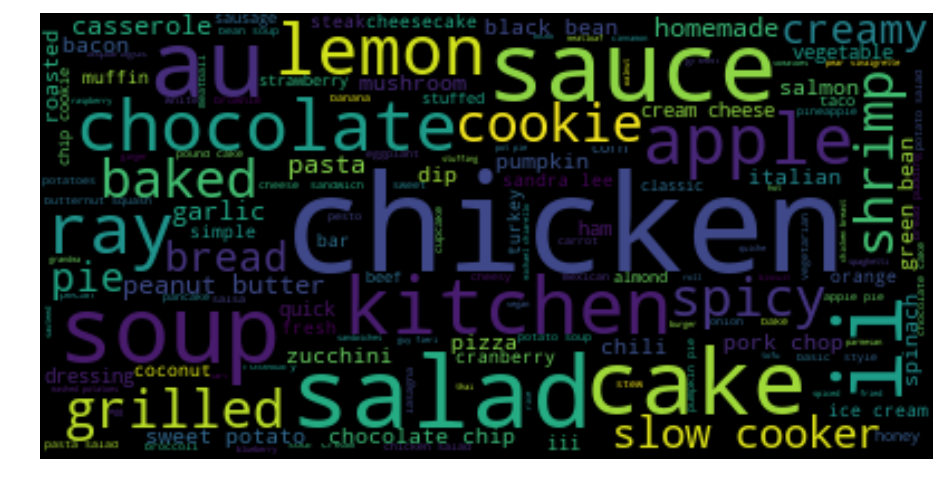

In [35]:
#text_words=['apple brown betty roasted potatoes north indian spices baked buffalo']
text_words=''
for word in flat_words:
    text_words=text_words+' '+word
    
#create WordCloud
wordcloud = WordCloud(max_font_size=60).generate(text_words)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("report/wordCloud.png")

## Clustering
We need to first tranform the titles to vectorspace

In [36]:
#1. initialize vectorizer (english, mono- and bigrams)
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

#2. fit (train) the vectorizer with the title strings (X)
tfidf_matrix = vectorizer.fit_transform(title_strings)

#Create a vocabulary list
terms = vectorizer.get_feature_names()


We can then train the Kmeans algorithm with the vectorized titles. The number of clusters is an essential parameter: with more clusters we get better resolution ('green bean casserole' instead of 'casserole') but the complexity of our model increases as well.

In [37]:
#Cluster vectors with kmeans
num_clusters = 10

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
#Train model on dataset
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

#add cluster to dataframe
df_train['Cluster']=clusters



Wall time: 3.3 s


### Analysis of clusters

We can extract n recipes per cluster that have the lowest carbon footprint but an excellent rating. With this dataframe, we can take any new recipe, find its corresponding cluster and recommend 3 recipes that are probably better for the environment but still delicious!

In [38]:
#recipe with lowest carbon footprint and highest rating
excellent_recipes=df_train[(df_train['Rating']>4.8)][['Cluster','Recipe Title', 'Has meat', 'Carbon footprint- Normalised','Rating']]

#Find best n recipes in cluster with lowest carbon footprint
n=3
#excellent_recipes.loc[excellent_recipes.groupby('Cluster')['Carbon footprint- Normalised'].idxmin()]
#excellent_recipes.groupby('Cluster')['Carbon footprint- Normalised'].nsmallest(5)
recommendations=excellent_recipes.loc[excellent_recipes.groupby('Cluster')['Carbon footprint- Normalised'].apply(lambda x: pd.Series(x.nsmallest(3).index)).values]
recommendations

,Cluster,Recipe Title,Has meat,Carbon footprint- Normalised,Rating
115,0,Peach Crisp Recipe : Anne Burrell : Recipes : ...,False,0.00000,5.00
1179,0,Slow Berry Cobbler Recipe : Paula Deen : Recip...,False,0.00000,5.00
2130,0,Rhubarb Peach Cobbler Recipe : Alton Brown : R...,False,0.00000,5.00
36,1,"Whole-Wheat Spaghetti with Lemon, Basil, and S...",False,0.00000,5.00
46,1,Berry Bircher Muesli Recipe - Taste.com.au,False,0.00000,5.00
59,1,Orzo with Smokey Tomato Vinaigrette Recipe : G...,False,0.00000,5.00
5285,2,Bourbon BBQ Chicken with Sixteen Spice Rub Rec...,False,0.00000,5.00
25244,2,Where's the Beach? Chicken Katsu Recipe : : ...,True,0.00480,5.00
3480,2,Buffalo Chicken Cheese Balls Recipe : Aaron Mc...,True,0.00576,5.00
1073,3,Apple Chutney Recipe : Ina Garten : Recipes : ...,False,0.00000,5.00


We can also examine the top terms per cluster to see what themes are captured by the clustering.

In [39]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
cluster_themes=[]
for i in range(num_clusters):
    #print("Cluster %d:" % i)
    val=''
    for ind in order_centroids[i, :3]:
        #print( ' %s' % terms[ind])
        if val: #not empty: add new term
            val=val+ ', ' + terms[ind]
        else: #empty, add first term
            val=terms[ind]
        
    cluster_themes.append(val)
    print('CLUSTER ',i, ': ',cluster_themes[i])
    
#cluster_themes=['meat lunches','apple pie','casserole', 'salad','soup','pasta', 'cake and cookies','pumpkin pie','beans','ice cream/cheese']
#cluster_themes=['salads','grilled chicken/salmon','chocolate cake', 'cheese','fried chicken recipes','soups','pie and cookies', 'potatoe/salads','casserole/pumpkin','roasted potatoes/garlic']

Top terms per cluster:

CLUSTER  0 :  peach, cobbler, peach cobbler
CLUSTER  1 :  soup, bread, pie
CLUSTER  2 :  chicken, chicken salad, soup
CLUSTER  3 :  apple, apple pie, pie
CLUSTER  4 :  sauce, cranberry sauce, tomato
CLUSTER  5 :  cookies, chocolate, chip
CLUSTER  6 :  potato, baked, sweet potato
CLUSTER  7 :  cake, chocolate, pound cake
CLUSTER  8 :  salad, pasta salad, pasta
CLUSTER  9 :  pumpkin, pumpkin pie, pie


Looking at the distribution of the carbon footprint and rating across these clusters we see that the chicken cluster has signicantly higher median carbon footprint than all other clusters.

Carbon footprint- Normalised                                      \
                               count      mean        std  min       25%   
Cluster                                                                    
0                              231.0  0.040189   0.290847  0.0  0.000000   
1                            19923.0  1.466869   8.325136  0.0  0.000000   
2                             2180.0  1.650396   2.686259  0.0  0.574611   
3                              555.0  0.367859   2.248864  0.0  0.000000   
4                             1125.0  1.454094  10.607097  0.0  0.000000   
5                              921.0  0.061593   0.343378  0.0  0.001600   
6                             1151.0  0.498814   2.008422  0.0  0.000000   
7                             1233.0  0.374507   1.021114  0.0  0.007200   
8                             1545.0  0.597356   7.260462  0.0  0.000000   
9                              517.0  0.312456   0.921978  0.0  0.002304   

                                          Rating                           \
              50%       75%         max    count      mean       std  min   
Cluster                                                                     
0        0.000000  0.000000    4.107143    231.0  4.425108  0.397926  3.0   
1        0.014400  0.574611  329.725000  19923.0  4.418780  0.545014  0.0   
2        0.624681  1.564626   28.163265   2180.0  4.388532  0.459479  0.0   
3        0.000000  0.028800   35.972455    555.0  4.419730  0.525773  0.0   
4        0.000000  0.574611  278.571429   1125.0  4.422444  0.559169  0.0   
5        0.011520  0.019200    4.296300    921.0  4.332465  0.494787  0.0   
6        0.014400  0.318937   27.437642   1151.0  4.382580  0.569411  0.0   
7        0.057600  0.115200   12.388898   1233.0  4.358719  0.513146  0.0   
8        0.000000  0.318937  277.806122   1545.0  4.475146  0.578160  0.0   
9        0.043200  0.145919   13.775510    517.0  4.392456  0.599646  0.0   

                               
          25%   50%  75%  max  
Cluster                        
0        4.20  4.40  4.7  5.0  
1        4.20  4.50  4.7  5.0  
2        4.10  4.40  4.7  5.0  
3        4.10  4.50  4.7  5.0  
4        4.10  4.50  4.8  5.0  
5        4.10  4.45  4.6  5.0  
6        4.15  4.50  4.7  5.0  
7        4.10  4.50  4.7  5.0  
8        4.30  4.55  4.8  5.0  
9        4.20  4.50  4.7  5.0

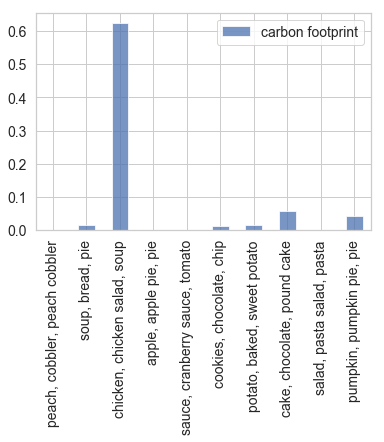

In [40]:
group_clusters=df_train.groupby('Cluster')['Carbon footprint- Normalised', 'Rating'].describe()
cf_clusters=group_clusters['Carbon footprint- Normalised']['50%']
rating_clusters=group_clusters['Rating']['50%']

cluster_medians_cf = pd.DataFrame({ 'cluster':cluster_themes, 'carbon footprint':cf_clusters.values})
cluster_medians_cf.set_index(["cluster"],inplace=True)
cluster_medians_cf.plot(kind='bar',alpha=0.75)
plt.xlabel("")
group_clusters


The median rating is around 4.4 across all clusters suggesting that no one cluster is consistently rated above another.

Text(0.5,0,'')

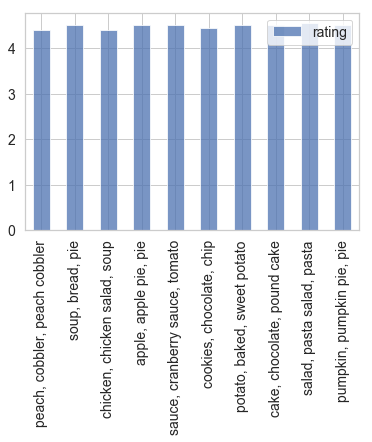

In [41]:
cluster_medians_ratings = pd.DataFrame({ 'cluster':cluster_themes, 'rating':rating_clusters.values})
cluster_medians_ratings.set_index(["cluster"],inplace=True)
cluster_medians_ratings.plot(kind='bar',alpha=0.75)
plt.xlabel("")

The 'soup, bread, pie' cluster clearly dominates. A possible reason for this is that the cluster themes are extremely broad, encompassing alot of recipes 

Carbon footprint- Normalised                                      \
                               count      mean        std  min       25%   
Cluster                                                                    
0                              231.0  0.040189   0.290847  0.0  0.000000   
1                            19923.0  1.466869   8.325136  0.0  0.000000   
2                             2180.0  1.650396   2.686259  0.0  0.574611   
3                              555.0  0.367859   2.248864  0.0  0.000000   
4                             1125.0  1.454094  10.607097  0.0  0.000000   
5                              921.0  0.061593   0.343378  0.0  0.001600   
6                             1151.0  0.498814   2.008422  0.0  0.000000   
7                             1233.0  0.374507   1.021114  0.0  0.007200   
8                             1545.0  0.597356   7.260462  0.0  0.000000   
9                              517.0  0.312456   0.921978  0.0  0.002304   

                                          Rating                           \
              50%       75%         max    count      mean       std  min   
Cluster                                                                     
0        0.000000  0.000000    4.107143    231.0  4.425108  0.397926  3.0   
1        0.014400  0.574611  329.725000  19923.0  4.418780  0.545014  0.0   
2        0.624681  1.564626   28.163265   2180.0  4.388532  0.459479  0.0   
3        0.000000  0.028800   35.972455    555.0  4.419730  0.525773  0.0   
4        0.000000  0.574611  278.571429   1125.0  4.422444  0.559169  0.0   
5        0.011520  0.019200    4.296300    921.0  4.332465  0.494787  0.0   
6        0.014400  0.318937   27.437642   1151.0  4.382580  0.569411  0.0   
7        0.057600  0.115200   12.388898   1233.0  4.358719  0.513146  0.0   
8        0.000000  0.318937  277.806122   1545.0  4.475146  0.578160  0.0   
9        0.043200  0.145919   13.775510    517.0  4.392456  0.599646  0.0   

                               
          25%   50%  75%  max  
Cluster                        
0        4.20  4.40  4.7  5.0  
1        4.20  4.50  4.7  5.0  
2        4.10  4.40  4.7  5.0  
3        4.10  4.50  4.7  5.0  
4        4.10  4.50  4.8  5.0  
5        4.10  4.45  4.6  5.0  
6        4.15  4.50  4.7  5.0  
7        4.10  4.50  4.7  5.0  
8        4.30  4.55  4.8  5.0  
9        4.20  4.50  4.7  5.0

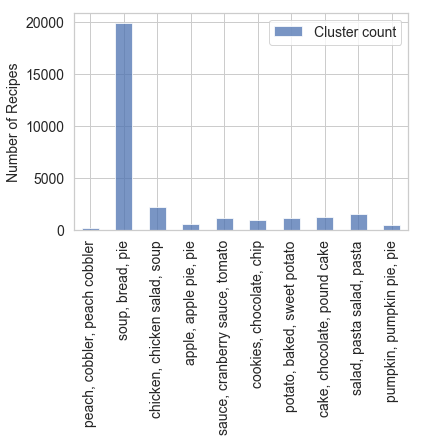

In [42]:
cluster_count = pd.DataFrame({ 'cluster':cluster_themes, 'Cluster count':group_clusters['Carbon footprint- Normalised']['count']})
cluster_count.set_index(["cluster"],inplace=True)
cluster_count.plot(kind='bar',alpha=0.75)
plt.ylabel("Number of Recipes")
plt.xlabel("")
group_clusters

Dropping this dominant cluster we can examine the other clusters better. We see that chicken and soups are now dominant.

Text(0.5,0,'')

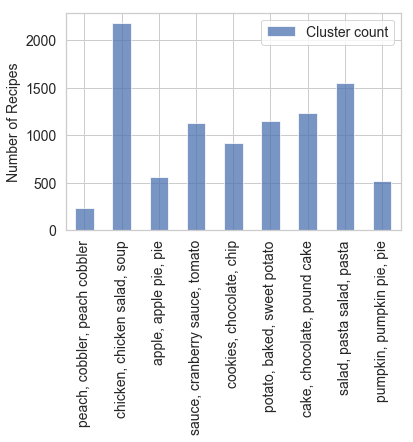

In [43]:
#Dropping the dominant cluster we can examine the other clusters better
cluster_count=cluster_count.drop([cluster_count['Cluster count'].argmax()])
cluster_count.plot(kind='bar',alpha=0.75)
plt.ylabel("Number of Recipes")
plt.xlabel("")

## Visualization of clusters
To visualize the clusters we need to project the vectors (which are in a high dimensional space) to 2D.


I commented out the next cell to avoid memory errors. Instead I loaded the png of the visual that we created in another notebook.

In [46]:
cluster_names= dict(enumerate(cluster_themes))

In [ ]:
"""
#Condense our sparse tfidf matrix
X=tfidf_matrix.todense()
#Run primary component analysis to project features onto 2 dimensions
pca=PCA(n_components=2).fit(X)
data2D=pca.transform(X)
cluster_colors={0:'#000000', 1:'#800000', 2:'#FF0000', 3:'#008000', 4:'#00FF00', 5:'#008080',6:'#00FFFF',7:'#000080', 8:'#0000FF', 9:'#800080'}
cluster_names= dict(enumerate(cluster_themes))
color_str=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
cluster_colors=dict(enumerate(color_str[0:10]))
G=pd.DataFrame(dict(x=data2D[:,0],y=data2D[:,1], label=clusters, title=titles))
#group by cluster
groups = G.groupby('label')

#set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    
    #ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
    #        label=cluster_names[name], color=cluster_colors[name], 
    #        mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point


#uncomment the below to save the plot if need be
plt.savefig('clusters_10.png', dpi=200)

"""

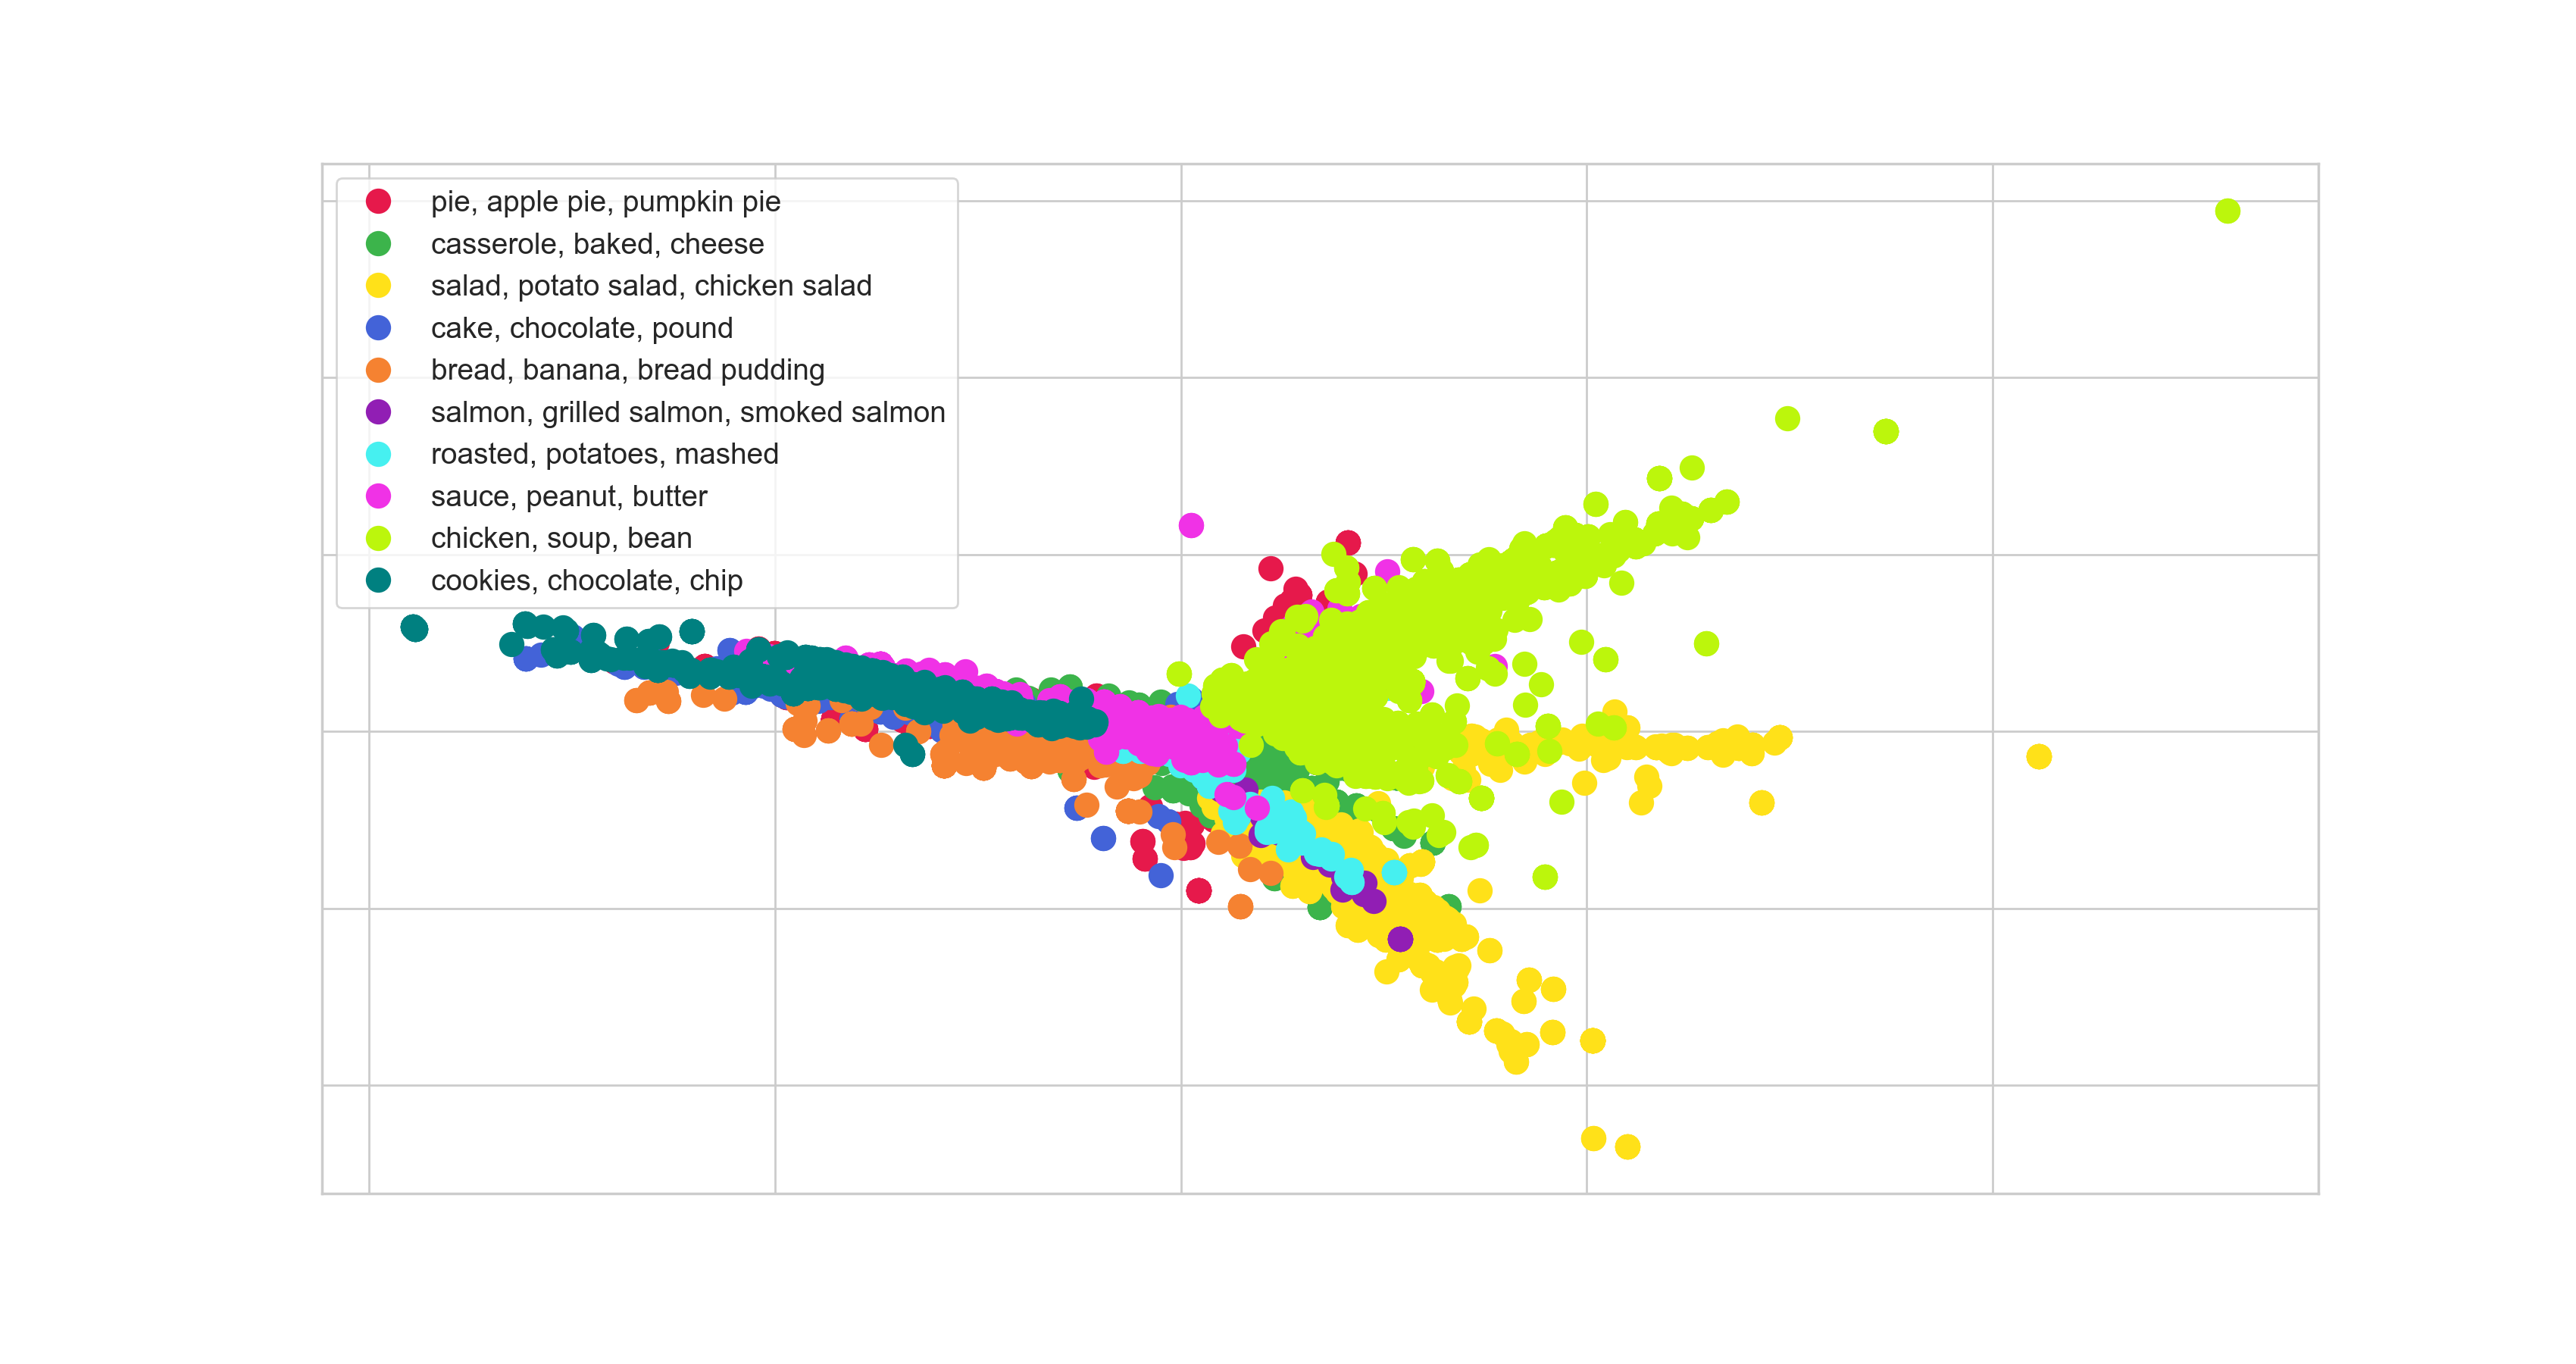

In [44]:
from IPython.display import Image
Image(filename='/data/clusters_10.png') 

### Cluster Prediction

To see if our clustering works, we can feed in new data and predict the cluster.

In [47]:
####PREDICTION
input_recipe='baked paprika parmesan chicken'
print('Input recipe: ' ,input_recipe)
Y=vectorizer.transform([input_recipe])
prediction=km.predict(Y)[0]
print('Predicted cluster= Cluster ',prediction, ' ', cluster_names[prediction])

Input recipe:  baked paprika parmesan chicken
Predicted cluster= Cluster  2   chicken, chicken salad, soup
